<h1>Qiskit Bell State (two entangled qubits)</h1>

In [1]:
# kernel extension for conditional cell execution
#
# set skip to True (%%skip True) in any block you want to skip

%reload_ext skip_extension

<h2>Step 0. Obtain the API_KEY from the .env file</h2>

In [2]:
from environs import Env
from IPython.display import display, Markdown

env = Env()

#env.read_env()                         # this does not work (?)
env.read_env('.env', recurse=False)     # read .env file, if it exists

token = env('IBM_QUANTUM_TOKEN')  

display(Markdown('<span style="color:red">>>> Token: ' + token[:5] + '...</span>'))     # Check that the starting characters of the token are printed

<span style="color:red">>>> Token: 4a7ea...</span>

<h2>Step 1.1. Create a simple circuit with two entangled qubits (Bell state)</h2>

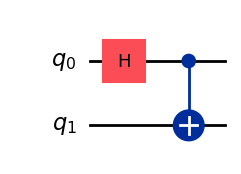

In [3]:
from qiskit import QuantumCircuit

# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

<h2>Step 1.2. Set up a set of observables</h2>

In [14]:
from qiskit.quantum_info import SparsePauliOp

# Set up six different observables.

labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]

observables = [SparsePauliOp(operator) for operator in labels]

display(Markdown('<span style="color:red">>>> "'+ str(len(labels)) + ' observables: ' +  str(labels)))

<span style="color:red">>>> "6 observables: ['IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XX']

<h2>Step 2.1.a. Set up backend for simulation</h2>

In [15]:
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2

backend = FakeAlmadenV2()

backend_name = backend.backend_name

<h2>Step 2.1.b. Alternatively set up backend for QPU</h2>

In [17]:
%%skip True      # set to True/False in order to skip/run this cell

display(Markdown('## <span style="color:red">>>>WARNING: *** No simulation. Next steps will run the circuit on hardware QPU ***</span>'))

from qiskit_ibm_runtime import QiskitRuntimeService

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

backend = service.least_busy(simulator=False, operational=True)

backend_name = backend.backend_name

<h2>Step 2.2. Convert to an ISA circuit layout</h2> 
<h3>(either for simulation or running on QPU)</h3>

<span style="color:red">>>> Execution backend: fake_almaden</span>

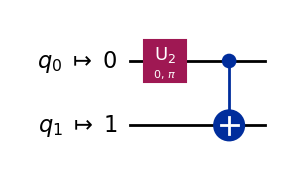

In [18]:
# Convert to an ISA circuit layout

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

display(Markdown('<span style="color:red">>>> Execution backend: ' + backend_name + '</span>'))

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)


<h2>Step 3'.1. Map the observables to the ISA circuit and construct the estimator instance</h2>

In [19]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Map the observables to the ISA circuit

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# print("Mapped observables: "+str(mapped_observables))

# Construct the Estimator instance

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1    # only needed for hardware QPU execution
estimator.options.default_shots = 5000

<h2>Step 3.2. Run or simulate the circuit</h2>

In [21]:
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later

job_id = job.job_id()

display(Markdown('<span style="color:red">>>> Save the job id for accessing the results when finished:<br>' +
                                         '>>> Job ID: ' + job_id + '</span>'))


c:\Users\canal\qiskitenv\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


<span style="color:red">>>> Save the job id for accessing the results when finished:<br>>>> Job ID: dcb6384c-8b91-4bdf-8af7-9a6802ed77f6</span>

<h2>Step 4.b. Retrieve a previously executed job</h2>
<h3>(only for execution on QPU)</h3>

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService

# In order to fully recover your Job object, you need the job id.
# When the job is done, you can recover the Job object like this:

service = QiskitRuntimeService(channel="ibm_quantum", token=token)

job_id = 'cwfpy200r6b0008pbrgg'
       # 'cwbzbjeggr6g00891070'      # job_id from a previous execution on hardware QPU

qpu_job = service.job(job_id)

<h2>Step 4.2. Show the results</h2>

<span style="color:red">>>> Job ID: cwfpy200r6b0008pbrgg</span>

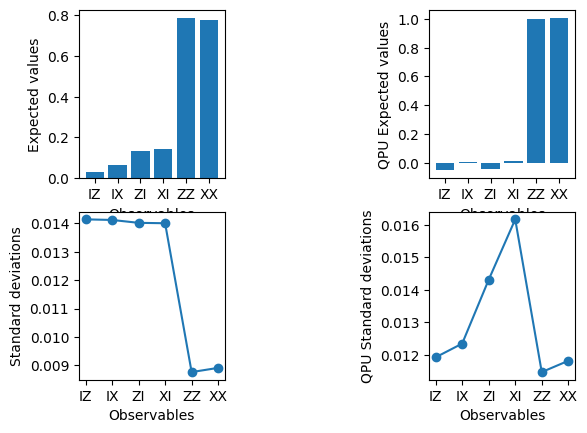

In [23]:
# Job for which we are showing the results.

display(Markdown('<span style="color:red">>>> Job ID: ' + job_id + '</span>'))


# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
qpu_result = qpu_job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
 
pub_result = job_result[0]
qpu_pub_result = qpu_result[0]

# Plot the results
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
qpu_values = qpu_pub_result.data.evs
 
errors = pub_result.data.stds
qpu_errors = qpu_pub_result.data.stds

# plotting graphs of values and errors

plt.subplot(2,3,1)  # 2 rows, 3 columns; this is the first plot
plt.bar(labels, values)
# plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Expected values')

plt.subplot(2,3,3)  # 2 rows, 3 columns; this is the third plot
plt.bar(labels, qpu_values)
# plt.plot(observables_labels, qpu_values, '-o')
plt.xlabel('Observables')
plt.ylabel('QPU Expected values')

plt.subplot(2,3,4) # 2 row, 3 columns; this is the first plot in the second row
# plt.bar(observables_labels, errors)
plt.plot(labels, errors, '-o')
plt.xlabel('Observables')
plt.ylabel('Standard deviations')

plt.subplot(2,3,6) # 2row, 3 columns; this is the last plot
# plt.bar(observables_labels, qpu_errors)
plt.plot(labels, qpu_errors, '-o')
plt.xlabel('Observables')
plt.ylabel('QPU Standard deviations')

plt.show()